In [1]:
import logging
import numpy as np
import matplotlib.pyplot as plt
import theano
import theano.tensor as T

import theano_shim as shim
import sinn
from sinn.histories import Spiketrain, Series
import sinn.iotools as io
import sinn.analyze as anlz
import sinn.optimize.gradient_descent as gd

import main
import fsgif_model as fsgif

import copy


np.set_printoptions(precision=3, suppress=True)
%matplotlib inline

try:
    # Guard against defining multiple loggers
    logger
except NameError:
    rootlogger = logging.getLogger()
    rootlogger.setLevel(sinn.LoggingLevels.MONITOR)

    sthandler = logging.StreamHandler()
    sthandler.setLevel(logging.INFO)
    sthandler.setFormatter(sinn.config.logging_formatter)
    rootlogger.addHandler(sthandler)
    
    filehandler = logging.handlers.RotatingFileHandler(
        'fsgif.log', mode='w', maxBytes=5e5, backupCount=5)
    filehandler.setLevel(sinn.LoggingLevels.MONITOR)
    filehandler.setFormatter(sinn.config.logging_formatter)
    rootlogger.addHandler(filehandler)
    
    logger = logging.getLogger('fsgif')
    logger.setLevel(logging.INFO)

[monochrome_palette]: value was greater than 1 and was clipped.


In [2]:
#theano.config.optimizer = 'None'
#theano.config.exception_verbosity = 'high'
theano.config.mode = 'FAST_COMPILE'

# Data generation

Generate spike trains. If the specified filename already exists, the precomputed data is used instead.

*Note*: Spike trains use relatively fine time bins (0.2&nbsp;ms). This is because spike times must be precise relative to the timescale of the PSP kernel (i.e. $τ_m$).

In [3]:
source_datalen = 4 # Use 4 seconds of data
datalen = 3.4      # Amount of data to use for likelihood
burnin = 0.5       # Amount of data to discard from likelihood
mbatch_size = 2    # Batch size when computing likelihood / gradients

In [4]:
spikemodel = main.generate_spikes(datalen,
                                  filename='fsgif_{}s_sin-input_hi-res.dat'.format(source_datalen))

2017-06-30 16:27:31,651 - root - INFO - Checking for precomputed data...
2017-06-30 16:27:32,076 - root - INFO - Precomputed data found. Skipping data generation


Compute the activity trace by summing over spikes. We subsample the result because the activity trace uses a coarser time bin of 1&nbsp;ms.

*Note*: When subsampling, we average over $n$ bins and combine into one, so we aren't just throwing away 80% of our data.

In [5]:
main.compute_spike_activity()

Plot the generated data.

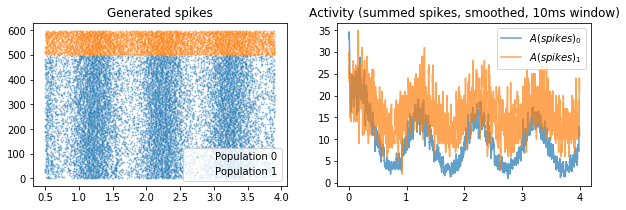

In [6]:
plt.figure(figsize=(10,3))

plt.subplot(1,2,1)
main.plot_raster(burnin, datalen)

plt.subplot(1,2,2)
main.plot_spike_activity()

In [7]:
mfmodel = main.derive_mf_model_from_spikes()

2017-06-30 16:27:33,451 - root - INFO - Producing Theano mean-field model.
2017-06-30 16:28:07,418 - theano_shim - INFO - Adding Theano update : θ_dis data -> IncSubtensor{Set;int64:int64:}.0
2017-06-30 16:28:07,420 - theano_shim - INFO - Adding Theano update : t idx (θ_dis) -> Elemwise{switch,no_inplace}.0
/home/alex/usr/venv/mackelab/lib/python3.5/site-packages/theano/tensor/basic.py:2146: UserWarning: theano.tensor.round() changed its default from `half_away_from_zero` to `half_to_even` to have the same default as NumPy. Use the Theano flag `warn.round=False` to disable this warning.
  "theano.tensor.round() changed its default from"
2017-06-30 16:28:07,428 - theano_shim - INFO - Adding Theano update : θtilde_dis data -> IncSubtensor{Set;int64:int64:}.0
2017-06-30 16:28:07,429 - theano_shim - INFO - Adding Theano update : t idx (θtilde_dis) -> Elemwise{switch,no_inplace}.0
/home/alex/usr/venv/mackelab/lib/python3.5/site-packages/theano/tensor/basic.py:2146: UserWarning: theano.tenso

In [8]:
# Clamp parameters: only parameters whose mask is set to True are fit
fitmask = {mfmodel.params.c: False,
           mfmodel.params.w: np.array([[True, False],
                                     [False, False]]),
           mfmodel.params.τ_m: np.array([False, True])}

In [9]:
sgd = gd.SGD(mfmodel.loglikelihood,
             optimizer = 'adam',
             model = mfmodel,
             burnin = burnin,
             datalen = datalen,
             mbatch_size = mbatch_size)

In [10]:
sgd.transform( mfmodel.params.τ_m, 'logτ_m',
               lambda τ: shim.log10(τ), lambda logτ: 10**logτ )

2017-06-30 16:28:30,435 - theano_shim - INFO - Clearing Theano updates
2017-06-30 16:28:30,450 - fsgif_model - INFO - Producing the likelihood graph.
/home/alex/usr/venv/mackelab/lib/python3.5/site-packages/theano/tensor/basic.py:2146: UserWarning: theano.tensor.round() changed its default from `half_away_from_zero` to `half_to_even` to have the same default as NumPy. Use the Theano flag `warn.round=False` to disable this warning.
  "theano.tensor.round() changed its default from"
2017-06-30 16:28:30,505 - theano_shim - INFO - Adding Theano update : y data -> IncSubtensor{Set;int64}.0
2017-06-30 16:28:30,507 - theano_shim - INFO - Adding Theano update : t idx (y) -> Elemwise{switch,no_inplace}.0
2017-06-30 16:28:30,522 - theano_shim - INFO - Adding Theano update : h_tot data -> IncSubtensor{Set;int64}.0
2017-06-30 16:28:30,523 - theano_shim - INFO - Adding Theano update : t idx (h_tot) -> Elemwise{switch,no_inplace}.0
2017-06-30 16:28:30,526 - theano_shim - INFO - Adding Theano update 

In [11]:
sgd.compile( fitparams = fitmask, 
             lr = 0.01
           )

2017-06-30 16:28:31,678 - theano_shim - INFO - Clearing Theano updates
2017-06-30 16:28:31,691 - sinn.optimize.gradient_descent - INFO - Producing the cost function theano graph
2017-06-30 16:28:31,693 - fsgif_model - INFO - Producing the likelihood graph.
/home/alex/usr/venv/mackelab/lib/python3.5/site-packages/theano/tensor/basic.py:2146: UserWarning: theano.tensor.round() changed its default from `half_away_from_zero` to `half_to_even` to have the same default as NumPy. Use the Theano flag `warn.round=False` to disable this warning.
  "theano.tensor.round() changed its default from"
2017-06-30 16:28:31,748 - theano_shim - INFO - Adding Theano update : y data -> IncSubtensor{Set;int64}.0
2017-06-30 16:28:31,749 - theano_shim - INFO - Adding Theano update : t idx (y) -> Elemwise{switch,no_inplace}.0
2017-06-30 16:28:31,770 - theano_shim - INFO - Adding Theano update : h_tot data -> IncSubtensor{Set;int64}.0
2017-06-30 16:28:31,771 - theano_shim - INFO - Adding Theano update : t idx (h

In [12]:
sgd.set_ground_truth(mfmodel.params)

evols = []

In [12]:
sgd.burnin_idx

500

In [12]:
def logL(model):
    return sum(sgd.)

array(-1)

In [14]:
import time

## New machine
First number: gradient evaluation <br>
Second number: likelihood evaluation

In [15]:
n = 10
i0 = 0

t1 = time.perf_counter()
for i in range(i0, i0+n):
    sgd._step(i)
t2 = time.perf_counter()
print((t2-t1)/n)

t1 = time.perf_counter()
for i in range(i0, i0+n):
    sgd.cost(i)
t2 = time.perf_counter()

print((t2-t1)/n)

4.71606696099916
0.2595898110012058


## Old Power Mac
First number: gradient evaluation<br>
Second number: likelihood evaluation

In [14]:
n = 10
i0 = 0

t1 = time.perf_counter()
for i in range(i0, i0+n):
    sgd._step(i)
t2 = time.perf_counter()
print((t2-t1)/n)

t1 = time.perf_counter()
for i in range(i0, i0+n):
    sgd.cost(i)
t2 = time.perf_counter()

print((t2-t1)/n)

29.315469363494778
0.36129934259224683


In [12]:
sgd.iterate(Nmax=1e3)

KeyboardInterrupt: 

In [13]:
sgd.step_i

0

In [11]:
logL_fn = theano.function([], logL_graph)

In [15]:
theano.printing.pydotprint(logL_fn, outfile="logL_pydot.png", scan_graphs=True)

The output file is available at logL_pydot_scan_fn_162.png
dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.827805 to fit

The output file is available at logL_pydot.png


In [13]:
logL_fn()

[array(-29679.126253179962)]

In [6]:
mfmodel = main.derive_mf_model_from_spikes()
gradlogL = main.compile_theano_gradloglikelihood2(mfmodel.params.w)

2017-06-27 21:55:47,167 - root - INFO - Producing Theano mean-field model.
2017-06-27 21:56:20,749 - theano_shim - INFO - Adding Theano update : θ_dis data -> IncSubtensor{Set;int64:int64:}.0
2017-06-27 21:56:20,750 - theano_shim - INFO - Adding Theano update : t idx (θ_dis) -> Elemwise{switch,no_inplace}.0
/home/alex/usr/venv/mackelab/lib64/python3.4/site-packages/theano/tensor/basic.py:2146: UserWarning: theano.tensor.round() changed its default from `half_away_from_zero` to `half_to_even` to have the same default as NumPy. Use the Theano flag `warn.round=False` to disable this warning.
  "theano.tensor.round() changed its default from"
2017-06-27 21:56:20,757 - theano_shim - INFO - Adding Theano update : θtilde_dis data -> IncSubtensor{Set;int64:int64:}.0
2017-06-27 21:56:20,758 - theano_shim - INFO - Adding Theano update : t idx (θtilde_dis) -> Elemwise{switch,no_inplace}.0
2017-06-27 21:56:21,287 - root - INFO - Theano model complete.
2017-06-27 21:56:21,288 - root - INFO - Produc

In [7]:
gradlogL(0.5, 3.4)

2017-06-27 21:57:12,656 - root - INFO - Computing loglikelihood gradient.
2017-06-27 21:57:48,860 - root - INFO - Done.


array([[-27.418,  -5.134],
       [ 18.957,   8.997]])

Create the activity model we will fit, with activity trace and input constrained by the spike data.

# Visual validation

To check that the models are consistent, we instantiate a second mean-field model with the same input but let it compute the activity trace. We check that the trace it produces is consistent with the one we will fit to.

In [6]:
mfmodel_unconstrained = main.init_mean_field_model(activity_history = None,
                                                   input_history = Ihist,
                                                   model_params = mfmodel.params)

mfmodel_unconstrained.A.name = 'A (mf)'

In [7]:
mfmodel_unconstrained.A.set()  # Compute A

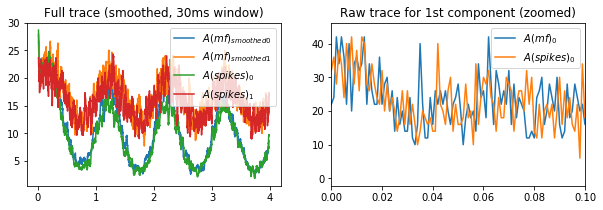

In [9]:
plt.figure(figsize=(10,3))

plt.subplot(1,2,1)
plt.title("Full trace (smoothed, 30ms window)")
anlz.plot(anlz.smooth(mfmodel_unconstrained.A, 30))
anlz.plot(anlz.smooth(Ahist, 30), label='A (spikes)')
plt.legend()

plt.subplot(1,2,2)
plt.title("Raw trace for 1st component (zoomed)")
anlz.plot(mfmodel_unconstrained.A, component=0)
anlz.plot(Ahist, label='A (spikes)', component=0)
plt.legend()
plt.xlim((0.0, 0.1))

None

# Likelihood sweep

In [14]:
# Workaround for issue with `sinn`
spikemodel.λ.name = 'spikeλ'
spikemodel.u.name = 'spikeu'

histnames_to_delete = ['A_subsampled_by_5_smoothed']
dellist = []
for h in mfmodel.history_inputs:
    if h.name in histnames_to_delete:
        dellist.append(h)
for h in dellist:
    del mfmodel.history_inputs[h]
    
dellist = []
for h in sinn.inputs:
    if h.name in histnames_to_delete:
        dellist.append(h)
for h in dellist:
    del sinn.inputs[h]

In [15]:
tidx = shim.getT().scalar('tidx', dtype='int32')
output_res_idx = mfmodel.nbar[tidx]

/home/alex/usr/venv/mackelab/lib64/python3.4/site-packages/theano/tensor/basic.py:2146: UserWarning: theano.tensor.round() changed its default from `half_away_from_zero` to `half_to_even` to have the same default as NumPy. Use the Theano flag `warn.round=False` to disable this warning.
  "theano.tensor.round() changed its default from"
2017-06-24 23:43:59,255 - theano_shim - INFO - Adding Theano update : A_Δ data -> IncSubtensor{Set;int64:int64:}.0
2017-06-24 23:43:59,255 - theano_shim - INFO - Adding Theano update : t idx (A_Δ) -> Elemwise{switch,no_inplace}.0
2017-06-24 23:43:59,271 - theano_shim - INFO - Adding Theano update : y data -> IncSubtensor{Set;int64}.0
2017-06-24 23:43:59,272 - theano_shim - INFO - Adding Theano update : t idx (y) -> Elemwise{switch,no_inplace}.0
2017-06-24 23:43:59,283 - theano_shim - INFO - Adding Theano update : h_tot data -> IncSubtensor{Set;int64}.0
2017-06-24 23:43:59,284 - theano_shim - INFO - Adding Theano update : t idx (h_tot) -> Elemwise{switch,

In [16]:
f = theano.function([tidx], updates=shim.cf.theano_updates)

In [17]:
mfmodel.theano_reset()

2017-06-24 23:44:00,473 - theano_shim - INFO - Clearing Theano updates


In [18]:
for i in range(3999):
    f(i)

In [19]:
mfmodel.nbar.lock()

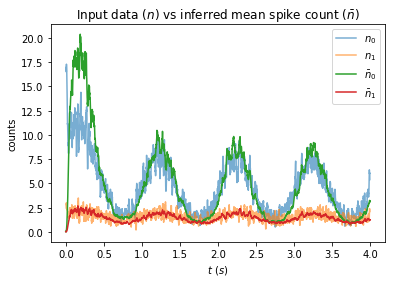

In [31]:
plt.title("Input data ($n$) vs inferred mean spike count ($\\bar{n}$)")
anlz.plot(anlz.smooth(mfmodel.n, 10), alpha=0.6, label="n")
anlz.plot(mfmodel.nbar, label="\\bar{n}")
plt.ylabel("counts")
plt.xlabel("$t$ ($s$)")
plt.legend()

In [27]:
mfmodel.n._original_data.get_value()[201:210]

array([[ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.]])

In [ ]:
%debug

> /home/alex/Recherche/macke_lab/code/sinn/sinn/histories.py(2699)set()
   2697                     raise ValueError("[Series.set] The given source series does not match the dimensions of this one.\n"
   2698                                      "Source shape: {}\nThis history's shape: {}."
-> 2699                                      .format(source.shape, tarr.shape + self.shape))
   2700                 data = source
   2701 

ipdb> up
> /home/alex/Recherche/macke_lab/code/sinn/sinn/analyze/analyze.py(215)smooth()
    213         res.pad(series.t0idx, len(series._tarr) - len(series) - series.t0idx)
    214             # Add the same amount of padding as series
--> 215         res.set(_running_mean(series[:], amount))
    216 
    217         return res

ipdb> series
ipdb> series.hist
ipdb> series.t0idx
101
ipdb> series[:].shape
(3999, 2)
ipdb> series.hist[:].shape
Shape.0
ipdb> series.hist[:].eval().shape
(4100, 2)
ipdb> series.hist.get_t_idx(slice(None, None))
slice(101, 4100, None)

In [53]:
anlz.analyze._running_mean(ndata, 10)

RuntimeError: The update function for history n data is not set.

In [42]:
arr = mfmodel.n._data.eval()
ndata = Series(name='n data', t0=0, tn=len(arr)-1, dt=1, shape=arr.shape[1:])
ndata.set(arr)

In [44]:
mfmodel.n.use_theano

False

In [34]:
mfmodel.n.t0idx

101

In [24]:
mfmodel.n._cur_tidx.eval()

array(4200)

In [20]:
list(shim.cf.theano_updates)[10].get_value()

array([[ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       ..., 
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.]])

In [35]:
theano.gof.graph.inputs([mfmodel.θ_dis._data])

[θ_dis data,
 <TensorType(float64, vector)>,
 t idx (θ_dis),
 TensorConstant{1},
 <TensorType(float64, vector)>,
 t idx (θtilde_dis),
 Constant{101},
 Constant{-1},
 Constant{0},
 TensorConstant{0.001},
 TensorConstant{0.001},
 Constant{-1},
 TensorConstant{0.001},
 TensorConstant{0.001},
 TensorConstant{100},
 TensorConstant{100},
 Constant{-1},
 TensorConstant{0},
 <TensorType(float64, vector)>,
 TensorConstant{1.0},
 Constant{0},
 Constant{1},
 height,
 TensorConstant{(1,) of 2},
 TensorConstant{0.0},
 TensorConstant{0.1},
 <TensorType(float64, row)>,
 <TensorType(float64, row)>,
 Constant{-1}]

In [20]:
theano.printing.debugprint(mfmodel.θ_dis._data)

IncSubtensor{Set;int64:int64:} [id A] ''   
 |θ_dis data [id B]
 |Subtensor{::int64} [id C] ''   
 | |Elemwise{add,no_inplace} [id D] ''   
 | | |Elemwise{switch,no_inplace} [id E] ''   
 | | | |Elemwise{and_,no_inplace} [id F] ''   
 | | | | |Elemwise{ge,no_inplace} [id G] ''   
 | | | | | |InplaceDimShuffle{0,x} [id H] ''   
 | | | | | | |Subtensor{::int64} [id I] ''   
 | | | | | |   |Subtensor{int64:int64:} [id J] ''   
 | | | | | |   | |<TensorType(float64, vector)> [id K]
 | | | | | |   | |ScalarFromTensor [id L] ''   
 | | | | | |   | | |Elemwise{add,no_inplace} [id M] ''   
 | | | | | |   | |   |t idx (θ_dis) [id N]
 | | | | | |   | |   |TensorConstant{1} [id O]
 | | | | | |   | |ScalarFromTensor [id P] ''   
 | | | | | |   |   |Elemwise{add,no_inplace} [id Q] ''   
 | | | | | |   |     |Elemwise{switch,no_inplace} [id R] ''   
 | | | | | |   |     | |Elemwise{gt,no_inplace} [id S] ''   
 | | | | | |   |     | | |Elemwise{switch,no_inplace} [id T] ''   
 | | | | | |   |     | |

In [24]:
list(shim.cf.theano_updates)[0].get_value().max()

0.0

In [15]:
main.likelihood_sweep(('w', (0,0)), ('τ_m', (0,)),
                      fineness = (10,2),
                      mean_field_model = mfmodel,
                      output_filename = 'fsgif_loglikelihood_{}s_sin-input_theano.dat'
                                        .format(datalen),
                      recalculate = False)

2017-06-19 13:22:59,107 - root - INFO - Computing log likelihood...
2017-06-19 13:22:59,110 - sinn.sweep - INFO - Evaluating sweep at [-0.5, 0.0030000000000000009]
2017-06-19 13:23:03,109 - sinn.sweep - INFO - Evaluating likelihood function.
2017-06-19 13:23:03,111 - theano_shim - INFO - Clearing Theano updates
/home/rene/usr/venv/mackelab/lib/python3.5/site-packages/theano/tensor/basic.py:2146: UserWarning: theano.tensor.round() changed its default from `half_away_from_zero` to `half_to_even` to have the same default as NumPy. Use the Theano flag `warn.round=False` to disable this warning.
  "theano.tensor.round() changed its default from"


RecursionError: maximum recursion depth exceeded while calling a Python object

In [17]:
mfmodel.u._cur_tidx.get_value()

array(0)

In [30]:
mfmodel.A_Δ._is_batch_computable()

True

In [18]:
[h.name for h in sinn.inputs if not h._is_batch_computable()]

['Y', 'P_λ', 'v', 'P_Λ', 'p', 'nbar', 'W']

In [17]:
[h._is_batch_computable() for h in sinn.inputs]

[True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 True,
 False,
 False,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 False,
 True,
 False,
 True,
 True]

In [21]:
[h.name for h in sinn.inputs[mfmodel.nbar]]

['Pfree', 'P_Λ', 'x', 'X', 'W']

In [22]:
[h._is_batch_computable() for h in sinn.inputs[mfmodel.nbar]]

[False, False, True, True, False]

In [23]:
[h.name for h in sinn.inputs[mfmodel.Pfree]]

['Pfree', 'λfree']

In [43]:
sinn.inputs[mfmodel.p]

AttributeError: 'GIF_mean_field' object has no attribute 'p'

In [47]:
[h.name for h in sinn.inputs[mfmodel.nbar]]

['X', 'Pfree', 'x', 'W', 'P_Λ']

In [49]:
[h._is_batch_computable() for h in sinn.inputs[mfmodel.nbar]]

[False, False, False, False, False]

In [51]:
[h.name for h in sinn.inputs[mfmodel.X]]

['m']

In [53]:
mfmodel.m._is_batch_computable()

False

In [54]:
[h.name for h in sinn.inputs[mfmodel.m]]

['P_λ', 'm']

In [56]:
mfmodel.θtilde_dis._is_batch_computable()

True

Below we plot the unnormalized likelihood. True parameters have non-zero probability (~5x less then the MLE).

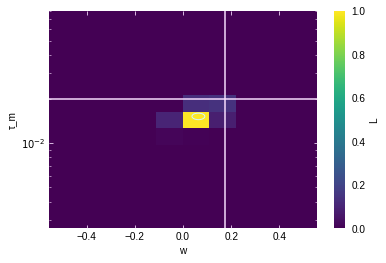

In [10]:
main.plot_likelihood('fsgif_loglikelihood_{}s_sin-input.dat'.format(datalen),
                     ellipse=None,
                     true_params=(true_params.w[0][0],
                                  true_params.τ_m[0]),
                     recalculate=True)

# Model equations

## Spiking model

\begin{gather}
u_{l, i} = \begin{cases}
u_{l-1, i} e^{-Δt/τ_m} + \bigl[u_{rest}^{α(i)} + R I_{ext}^{α(i)}(l) + R I_{syn, i}(l) \bigr]  (1 - e^{-Δt/τ_m}) & \text{if $\hat{t}_i \geq t_{ref}^{α(i)}$} \\
u_{rest}^{α(i)} & \text{otherwise}
\end{cases}
\end{gather}